## Machine Learning exam, Andrea Milici

IF YOU WANT TO RUN IT IN TEOGPU (SUGGESTED) VIA VSCODE use "amilici_exam" conda environment as jupyter kernel. 

IF YOU WANT TO RUN IT IN GOOGLE COLAB YOU SHOULD DOWNLOAD THE PROJECT IN YOUR OWN DRIVE AND THEN USE THE FOLLOWING LINES AND MAKE SURE TO SET GPU T4 RUNTIME:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import sys 
#sys.path.append('/content/drive/MyDrive/ml_exam/quench_project') #YOUR PATH TO THE PROJECT IN GOOGLE DRIVE
#%cd /content/drive/MyDrive/ml_exam/quench_project 
#!pwd
#file = '' # YOUR PATH TO THE FILE IN GOOGLE DRIVE


# Detection of quenches of superconducting cables from heat map sequences

## Introduction

We consider a grid of $n\times n$, with $n=15$ magnesium diboride $\rm{MgB}_{2}$ superconducting cables, conducting a current of $18$ kA at $20$ K. The cables maintain their superconducting phase below a critical temperature of $\approx 25$ K, above which they lose their superconducting property (it is said that they _quench_). The cables can be represented as cells in a grid and for each cable the temperature is sampled every hour in cycles of 24 hours (we indicate time steps in the sequence with $t=1,\ldots 24$). Every 24 hours the system is reset in its initial state. 

Despite the cables being isolated and separately cooled, the heat exchange among them is still not vanishing and can be modeled as a heat diffusion equation across the cables grid with a small, known heat diffusion coefficient. Due to the environment in which the cables operate, it can happen that one or more cables suddenly heat, and consequently quench. Their change of temperature propagates through the heat diffusion equation to the matrix of cables and the superconducting phase is recovered only when the heated cables go back to a temperature below $\approx 25$ K. Quenching is detected through current measurements, and it is not inferred by temperature measurements. We are interested in establishing a relation between heat maps and the occurrence of quenches.

## Data description

The input data are sequences of heat maps of the cables grid. As already mentioned, the grid is $15\times 15$ dimensional and the sequences contain $24$ measurements. 

A set of truth labels are also given to build supervised tasks. The first label, with values $0$ and $1$, indicates the category corresponding to no-quenches or at least one quench, respectively. Moreover, for sequences belonging to category $1$, additional labels are available representing the coordinates of the quenches $(t,x,y)$ with $t$ the step in the sequence, and $(x,y)$ the coordinates in the grid.

Available data are $3000$ labeled sequences of heat maps in the form of a python dictionary with the following structure:

```python
data = [
    {
        "sequence": np.array(...),  # A NumPy array of shape (seq_length, grid_size * grid_size)    
                                    
        "label": 0                  # Label 0 indicates a sequence without quenches
    },
    {
        "sequence": np.array(...),  # A NumPy array of shape (seq_length, grid_size * grid_size) 
                                    
        "label": 1,                 # Label 1 indicates a sequence containing at least one quench
        "quench": [
            {
                "step": 10,         # The time step in the sequence at which the anomaly occurred
                "pixel": [2, 3],    # The coordinates of the anomalous pixel
                "temp": 25.32       # The temperature of the anomalous pixel at the time of the anomaly
            },
            ... # Additional quenches
        ]
    }
    ... # Additional sequences
]
```

## Objective

1. Build a classifier able to distinguish sequences containing at least one quench from sequences not containing any quench (categories $0$ and $1$)
2. Try to infer the number of quenches in sequences assigned to category $1$
3. (optional) Try to characterize the sequences assigned to category $1$ by predicting the coordinates of the quenching cables (in time, in space, and/or both)


## Approach to Task 1
To solve this task, I explored two different approaches:

- **3D Convolutional Neural Network (CNN3D):**  
  I initially implemented a compact 3D CNN to capture both spatial and temporal patterns in the thermal map sequences. This model processes the full $(24, 15, 15)$ input as a 3D volume and was designed with a reduced number of parameters to prevent overfitting due to the relatively small dataset size.

- **Anomaly Detection with a Variational Autoencoder (VAE):**  
  I also investigated a more unsupervised approach using a 3D Variational Autoencoder. The VAE was trained to reconstruct sequences without quenches (label 0), learning a compact 2-dimensional latent space. Sequences with quenches (label 1) typically show higher reconstruction errors, making it possible to detect anomalies based on a threshold. This approach is particularly interesting because it does not rely directly on the labels for training the core encoder-decoder structure and offers potential insights into the latent representation of anomalous patterns.



In [2]:
from data.DataExplorator import DataExplorator
from data.QuenchDataLoader import QuenchDataLoader


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from utils.conv import output_dim
from utils.model_utils import count_parameters,reset_weights
from utils.seed import set_seed
set_seed(42)

Loading the dataset, by default converted in (N,24,15,15). Dataloader.get_data() returns a pandas dataframe with columns from the original dataset plus another one containing the number of quenches per sequence

In [3]:
file = '/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data_quench.json'  # path for quench dataset in genoa cluster
dataloader = QuenchDataLoader(file) # transform_to_2d= True by default
data= dataloader.get_data()

In [4]:
data[data.label==1].head(10)

,sequence,label,quench,num_quench
8,"[[[22.582478486789327, 22.904808739314365, 22....",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909...",1.0
9,"[[[22.0373877189044, 18.636944579237863, 21.76...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312...",7.0
20,"[[[21.411886934355916, 23.16618378647687, 20.1...",1,"[{'step': 14, 'pixel': [7, 7], 'temp': 24.8999...",1.0
21,"[[[21.276068279076245, 20.97700816985905, 21.2...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 24.4713...",2.0
23,"[[[21.69330864976891, 19.39115826850467, 20.55...",1,"[{'step': 15, 'pixel': [10, 13], 'temp': 25.69...",1.0
24,"[[[20.595254805733557, 20.533835363533974, 21....",1,"[{'step': 5, 'pixel': [2, 8], 'temp': 24.57916...",5.0
25,"[[[21.407920520604538, 21.456477400527827, 21....",1,"[{'step': 9, 'pixel': [9, 3], 'temp': 24.14381...",3.0
30,"[[[21.18585619997791, 22.480335406188853, 20.6...",1,"[{'step': 11, 'pixel': [4, 13], 'temp': 24.165...",1.0
33,"[[[21.86548024556175, 20.295758665609636, 19.6...",1,"[{'step': 5, 'pixel': [12, 10], 'temp': 25.103...",5.0
49,"[[[21.42555616027644, 20.86520132076076, 20.77...",1,"[{'step': 5, 'pixel': [6, 1], 'temp': 24.61992...",3.0


# Data exploration

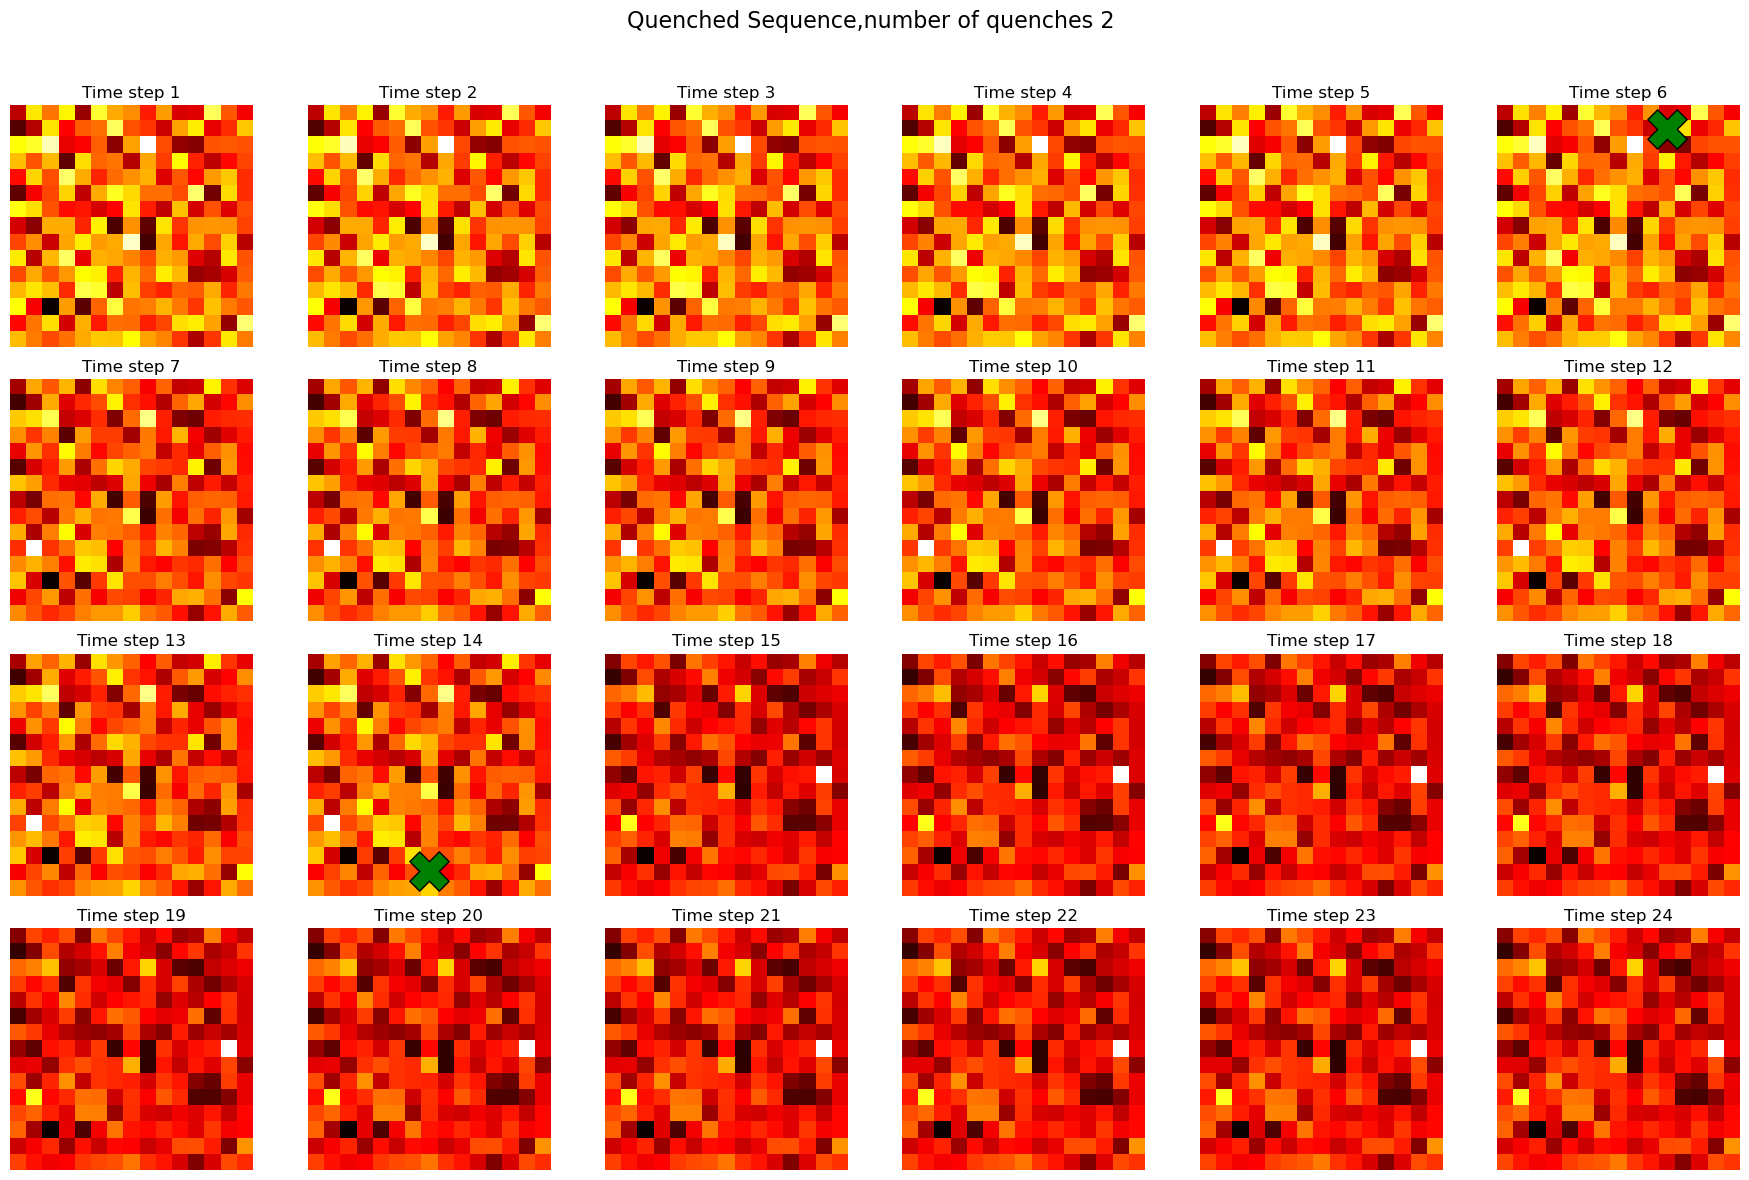

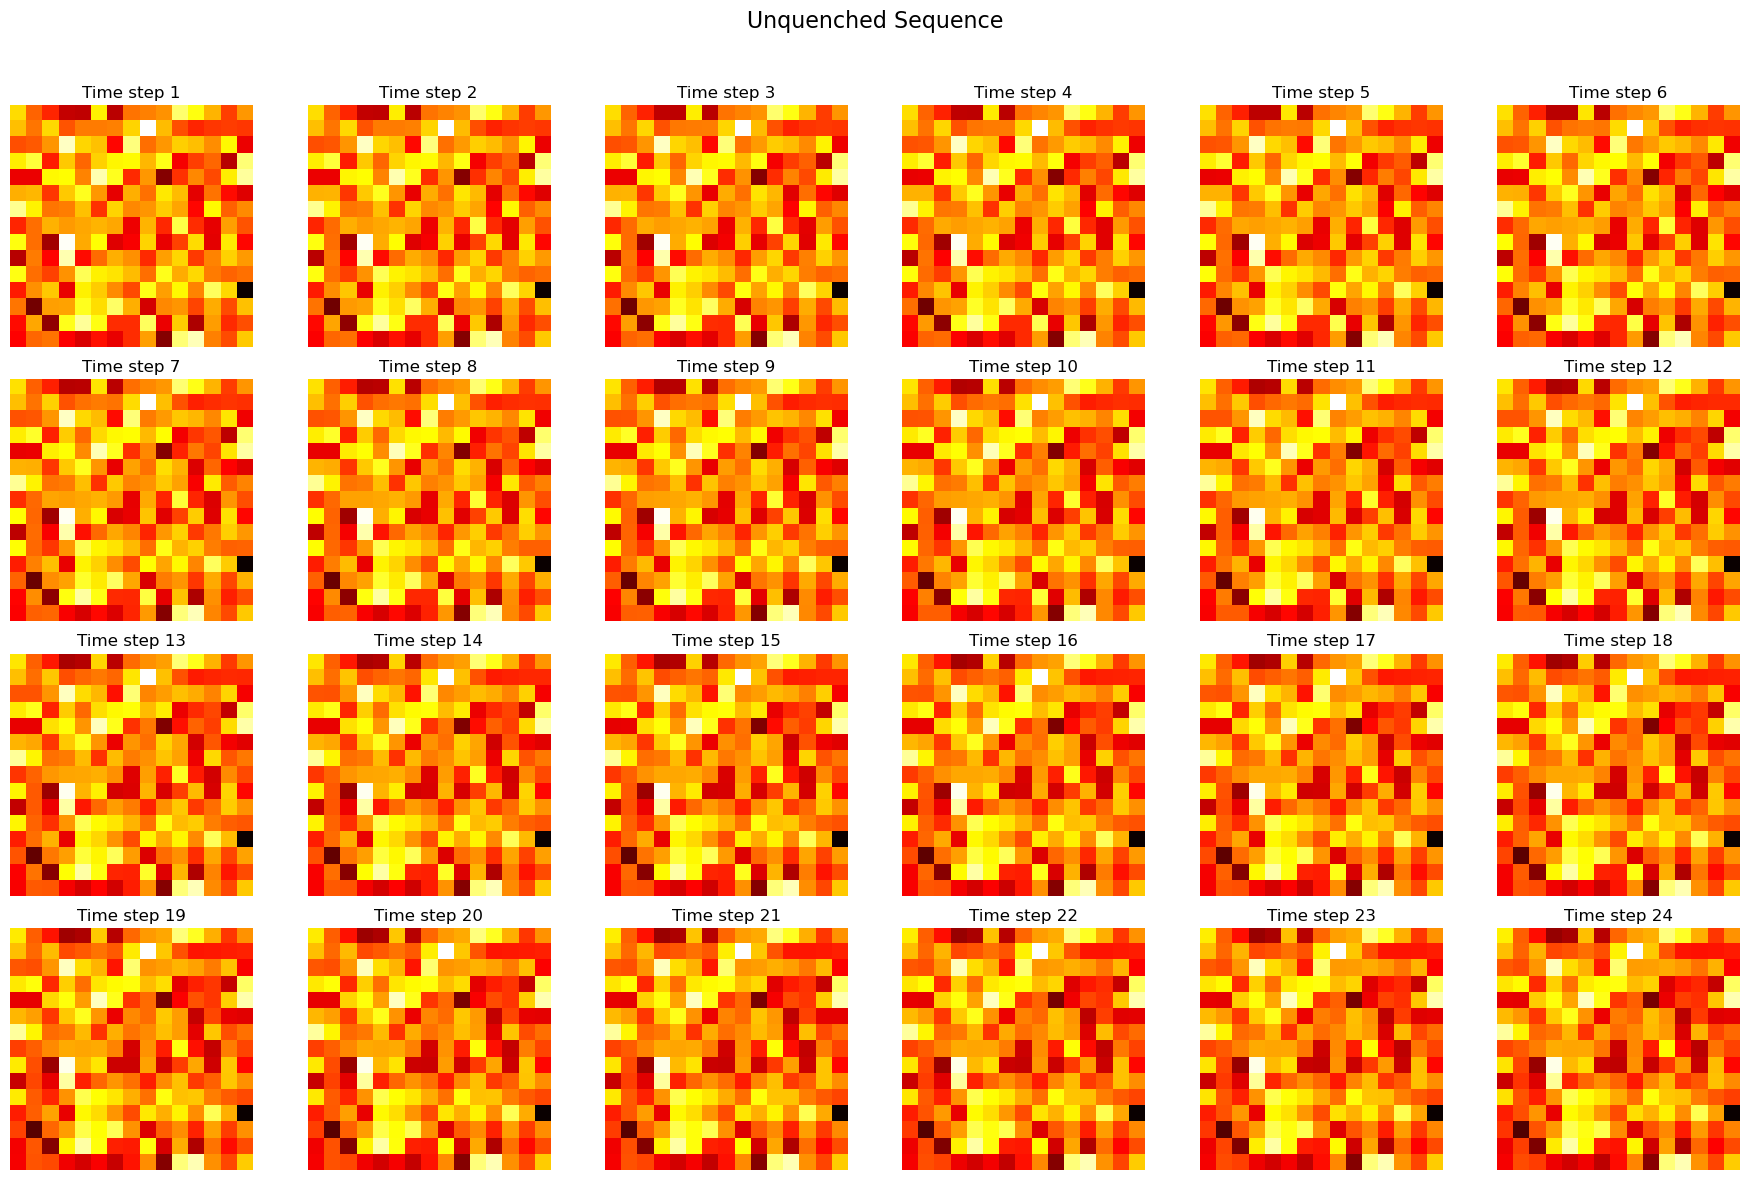

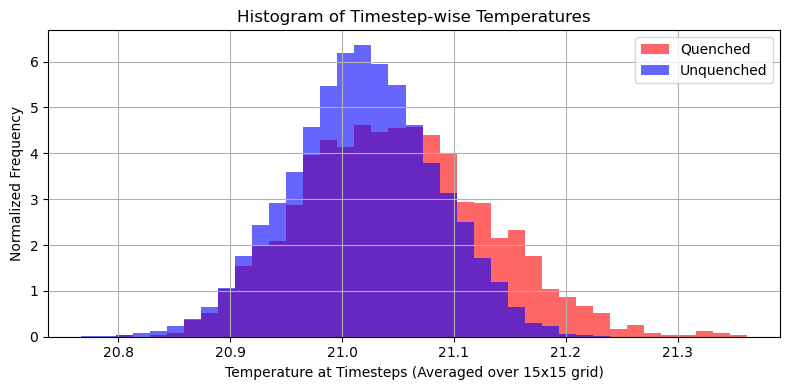

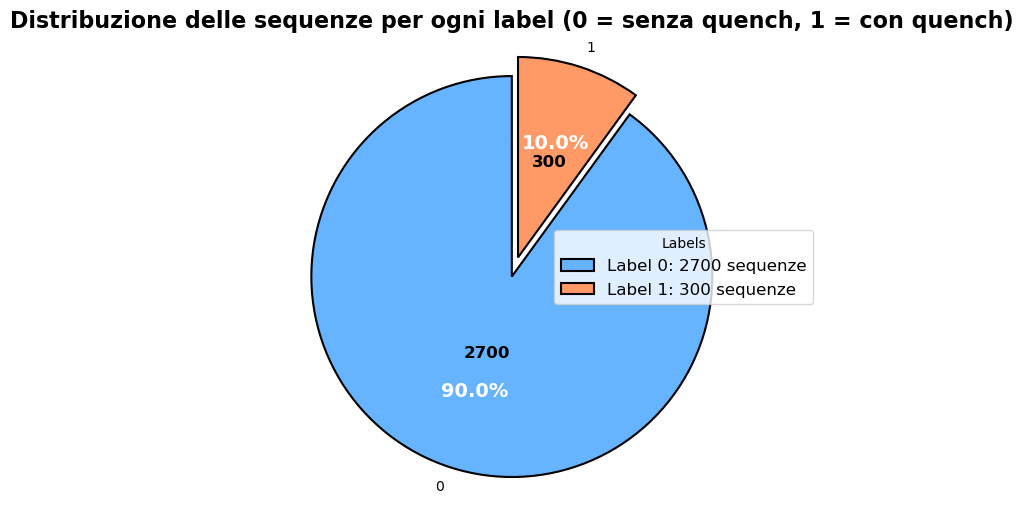

In [5]:
exploration = DataExplorator(data) 
# Let's visualize a  sequence of heatmaps with label == 1
exploration.visualize_sequence(quenched=True)
# Let's visualize a sequence of heatmaps with label == 0
exploration.visualize_sequence(quenched=False)
exploration.more_data_exploration()

### Data Normalization: Min-Max Scaling

To ensure that the input values are on a similar scale and to facilitate neural network training, I apply **Min-Max Scaling** to the temperature values in the heat map sequences.

Min-Max Scaling rescales the data to a fixed range, typically $[0, 1]$, according to the formula:

$$
x_{\text{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

where:
- $x$ is the original temperature value,
- $x_{\min}$ and $x_{\max}$ are the global minimum and maximum temperature values observed over the whole dataset.




In [6]:
def apply_min_max_scaling(data):
    all_values = np.concatenate([sequence.flatten() for sequence in data.sequence])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    denom = global_max - global_min
    data.sequence = (data.sequence- global_min)/denom
    return None

apply_min_max_scaling(data)


Possibly, we can downsample the dataset to get a balanced one.

In [7]:
from sklearn.utils import resample
import pandas as pd

downsampling = False

if downsampling:
    
    print("Downsampling the majority class to balance the dataset...")
    class0 = data[data.label == 0]
    class1 = data[data.label == 1]

    # Downsampling the majority class (class 0)
    class0_downsampled = resample(class0, 
                                       replace=False,     
                                       n_samples=300,     
                                       random_state=42)
    
    # Concatenate the downsampled majority class with the minority class (class 1)
    df_balanced = pd.concat([class0_downsampled, class1], ignore_index=True)
    data = df_balanced.sample(frac=1, random_state=42).copy()


In torch_Dataset are implemented classes derived from torch.Dataset providing torch-friendly dataset with the correct labels for each task
```python
from data.torch_Dataset import torch_Dataset_task1
```

In [8]:
from data.torch_Dataset import torch_Dataset_task1
full_dataset = torch_Dataset_task1(data)

# Train/test split
from torch.utils.data import DataLoader
from torch.utils.data import random_split
test_ratio = 0.2
test_size = int(len(full_dataset) * test_ratio)
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train dataset size: {len(train_dataset)}")  
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2400
Test dataset size: 600


## First Approach: Compact CNN-3D

### CNN_3D Model Summary

```python
from models.CNN_3D import CNN_3D
```

| Layer (type)        | Output Shape        | Param # | Notes                                     |
|---------------------|---------------------|---------|-------------------------------------------|
| Input               | (1, 24, 15, 15)     | 0       | Input: single-channel 3D volume           |
| Conv3d (1→8)        | (8, 24, 15, 15)     | 224     | Kernel: 3×3×3, Padding: 1                 |
| ReLU                | (8, 24, 15, 15)     | 0       |                                           |
| MaxPool3d           | (8, 12, 7, 7)       | 0       | Kernel: 2×2×2                             |
| Dropout (optional)  | (8, 12, 7, 7)       | 0       | Applied only if `dropout=True`           |
| Conv3d (8→16)       | (16, 12, 7, 7)      | 3,472   | Kernel: 3×3×3, Padding: 1                 |
| ReLU                | (16, 12, 7, 7)      | 0       |                                           |
| MaxPool3d           | (16, 6, 3, 3)       | 0       | Kernel: 2×2×2                             |
| Flatten             | (864,)              | 0       | 16×6×3×3 = 864 features                   |
| Linear (864→1)      | (1,)                | 865     | Final binary classification logit output |

**Total parameters**: **4,561**  
**Trainable parameters**: **4,561**  
**Non-trainable parameters**: **0**

---


### 🔧 Loss Function: `BCEWithLogitsLoss`

For the binary classification task — determining whether a thermal map sequence contains at least one quench — I used the following PyTorch loss function:

```python
loss_fn = nn.BCEWithLogitsLoss(pos_weight=None)
```



`BCEWithLogitsLoss` is a loss function specifically designed for **binary classification tasks** when the model outputs **logits** (real-valued scores). It combines two operations:

1. **Applies the Sigmoid function** to convert logits into probabilities:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

2. **Computes the Binary Cross Entropy (BCE)**:

$$
\text{BCE}(x, y) = -y \cdot \log(\sigma(x)) - (1 - y) \cdot \log(1 - \sigma(x))
$$ 
---

PyTorch bundles these operations into a single, **numerically stable** function: `BCEWithLogitsLoss`. This design helps to avoid numerical issues (like overflow or underflow) that can arise when applying the Sigmoid function followed by `BCELoss` separately.

In summary, `BCEWithLogitsLoss` is the preferred loss function when your model returns raw logits and you’re working on a binary classification task.


In [9]:
from models.CNN_3D import CNN_3D
model = CNN_3D()
count_parameters(model)

# Loss 
pos_weight= torch.tensor([len(data[data.label==0])/len(data[data.label==1])])  # Weight for the positive class
print("Pos weight:", pos_weight.numpy())

loss_BCEWithLogits= nn.BCEWithLogitsLoss(pos_weight=None)  

#---Training---

from train.trainer import TrainerCNN3D
from train.trainer import Results
lr= 1e-3
num_epochs = 10
trainer = TrainerCNN3D(model, loss_BCEWithLogits,optimizer='Adam',lr=lr, num_epochs=num_epochs, train_loader=train_loader ,val_loader=test_loader)
results=trainer.run()


Total parameters: 4561, Trainable parameters: 4561
Pos weight: [9.]
Epoch 01 | Train Loss: 0.0109 | Val Loss: 0.0121 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 02 | Train Loss: 0.0105 | Val Loss: 0.0106 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 03 | Train Loss: 0.0105 | Val Loss: 0.0106 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 04 | Train Loss: 0.0105 | Val Loss: 0.0103 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 05 | Train Loss: 0.0105 | Val Loss: 0.0123 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 06 | Train Loss: 0.0105 | Val Loss: 0.0115 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 07 | Train Loss: 0.0104 | Val Loss: 0.0106 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 08 | Train Loss: 0.0104 | Val Loss: 0.0111 | Val Acc: 90.83% | Val Prec: 0.00% | Val Recall: 0.00%
Epoch 09 | Train Loss: 0.0104 | Val Loss: 0.0104 | Val Acc: 90.83% | Val Prec: 0.00% | Val R

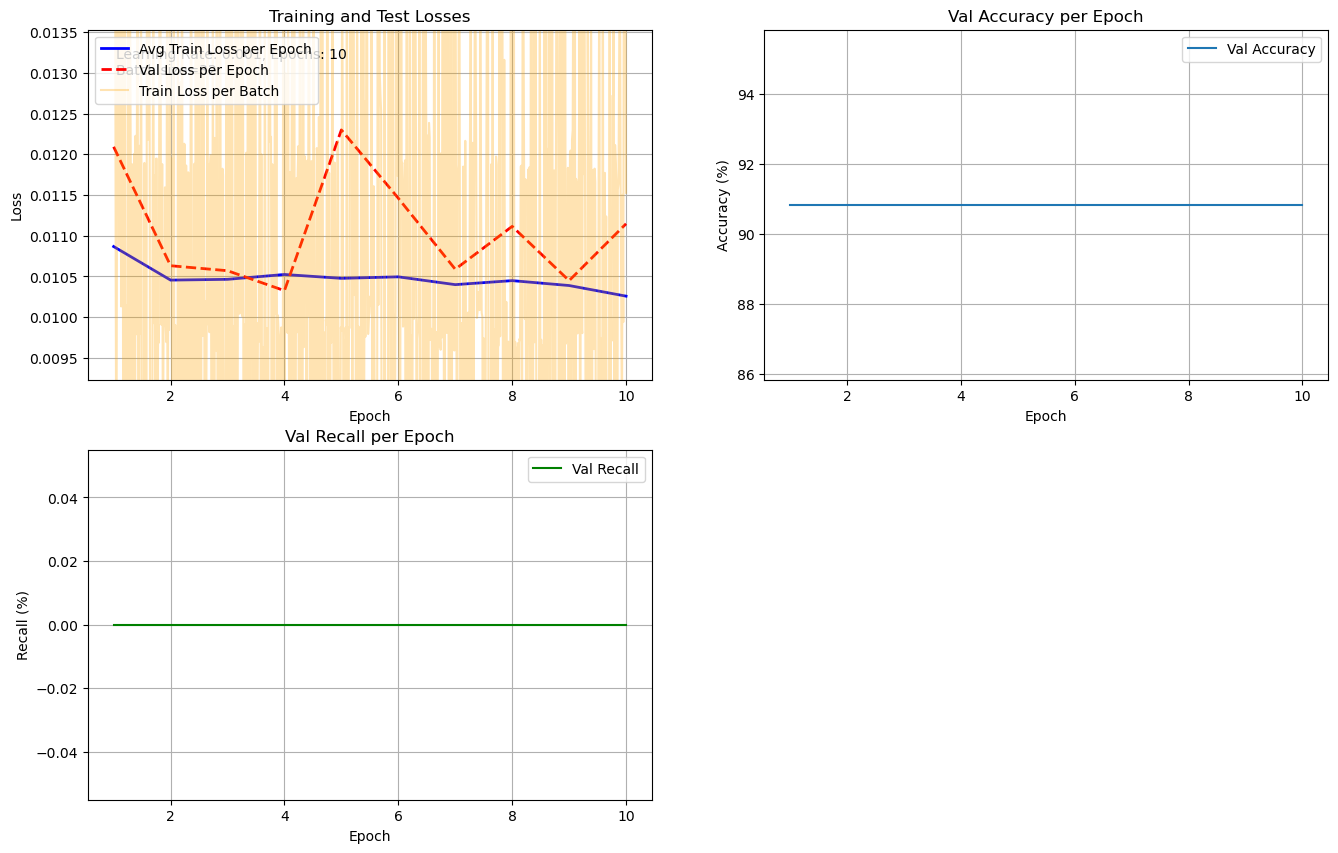

In [10]:
from utils.plot import plot_results_from_training
fig=plot_results_from_training(results,trainer)
fig.savefig(f'plots/task1/CNN3D/results_CNN_3D_lr={lr}_epochs={num_epochs}.png', dpi=300, bbox_inches='tight')
fig.show()


### 🧪 Test Metrics 

- **Precision:**  
  Precision measures the proportion of correctly predicted positive samples out of all samples predicted as positive:

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensitivity):**  
  Recall measures the proportion of correctly predicted positive samples out of all actual positive samples:

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **Accuracy:**  
  Accuracy measures the overall proportion of correctly classified samples (both positive and negative):

  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **F1-score:**  
  The harmonic mean of precision and recall, giving a balance between the two:

  $$
  F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Confusion Matrix:**  
  A table showing the counts of:  
  - True Positives (TP)  
  - True Negatives (TN)  
  - False Positives (FP)  
  - False Negatives (FN)  
  It gives a direct insight into the types of errors the model makes.

- **ROC AUC (Receiver Operating Characteristic - Area Under Curve):**  
  Measures the model's ability to distinguish between the two classes across all classification thresholds.  
  A value close to 1 indicates excellent separability, 0.5 means random guessing.

- **ROC Curve:**  
  Plots True Positive Rate (Recall) against False Positive Rate (FPR) at various threshold settings.  
  It helps to visualize the trade-off between sensitivity and specificity.

- **Precision-Recall (PR) Curve:**  
  Plots Precision against Recall for different thresholds.  
  This curve is particularly informative when dealing with imbalanced datasets where the positive class is rare.


================================ Classification Report ==============================================

              precision    recall  f1-score     support
Unquenched     0.908333  1.000000  0.951965  545.000000
Quenched       0.000000  0.000000  0.000000   55.000000
accuracy       0.908333  0.908333  0.908333    0.908333
macro avg      0.454167  0.500000  0.475983  600.000000
weighted avg   0.825069  0.908333  0.864702  600.000000 

ROC AUC: 0.7922602168473728 

y_all= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
random y= [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
model y= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

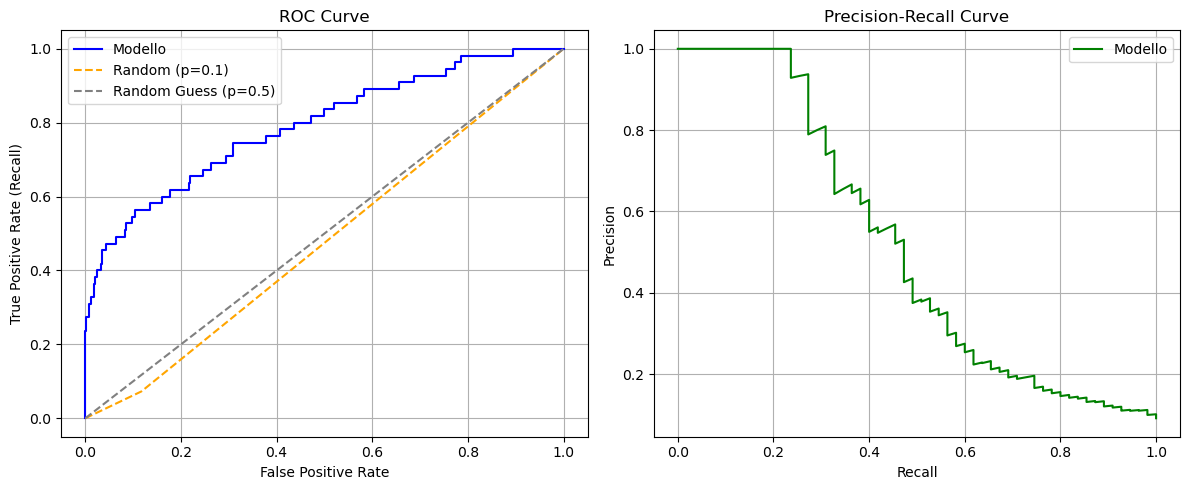

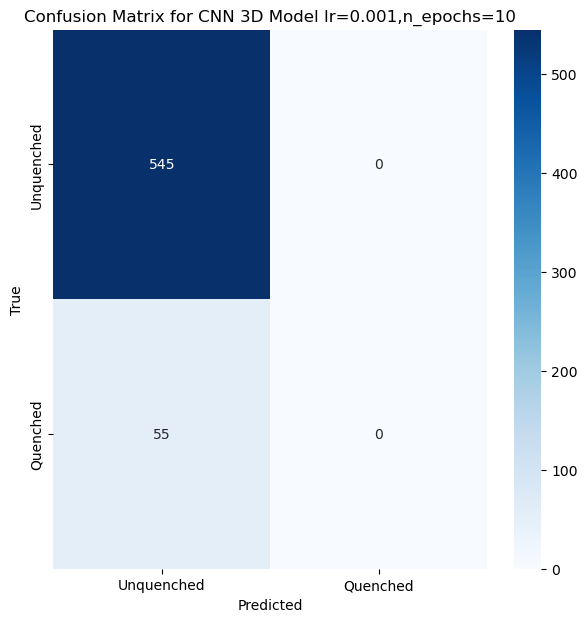

In [11]:

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from utils.plot import plot_confusion_matrix  

x_all = torch.stack([x for x, y in test_dataset])
y_all = torch.stack([y for x, y in test_dataset])

model.eval()
model.to('cpu')

with torch.no_grad():
    logits = model(x_all)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

y_all = y_all.numpy().reshape(-1)
preds = preds.numpy().reshape(-1)

print("================================ Classification Report ==============================================\n")
report_dict= classification_report(y_all, preds, output_dict=True,target_names=["Unquenched", "Quenched"], digits=4)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_json(f"reports/task1/classification_report_task1_CNN3D_lr{lr}_epochs{num_epochs}.json", index=True)
print(df_report, "\n")
print("ROC AUC:", roc_auc_score(y_all, probs), "\n")

# ROC e Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_all, probs)
precision, recall, _ = precision_recall_curve(y_all, probs)

# === Random classifier with binomial distribution (p=0.1 for class 1) ===
random_preds = np.random.binomial(n=1, p=0.1, size=len(y_all))

print("y_all=",y_all[0:20])
print("random y=",random_preds[0:20])
print("model y=",preds[0:20])


fpr_rand, tpr_rand, _ = roc_curve(y_all, random_preds)

# === Plot delle curve ROC e Precision-Recall ===
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='Modello', color='blue')
plt.plot(fpr_rand, tpr_rand, label='Random (p=0.1)', linestyle='--', color='orange')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess (p=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Modello', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

fig=plot_confusion_matrix(y_all, preds, labels=["Unquenched", "Quenched"],fig_size=(7, 7),title=f"Confusion Matrix for CNN 3D Model lr={lr},n_epochs={num_epochs}" )
fig.savefig(f"plots/task1/CNN3D/confusion_matrix_task1_CNN3D_lr{lr}_epochs{num_epochs}.png", dpi=300, bbox_inches='tight')
fig.show()


## Second Approach: Anomaly detection
### 🔍 Why Use a Variational Autoencoder (VAE) for Anomaly Detection?

In our dataset, the sequences **with quench events (label = 1)** are significantly fewer compared to the **normal sequences (label = 0)**. This class imbalance poses a challenge for traditional supervised classifiers, which may become biased toward the majority class and struggle to correctly identify rare anomalies.

To address this, I explored a **semi-unsupervised anomaly detection approach** using a **Variational Autoencoder (VAE)** built upon the previous model.

---

###  What is a Variational Autoencoder (VAE)?

A **VAE** is a type of autoencoder that not only learns to reconstruct the input but also learns a **probabilistic latent representation** of the data. It consists of two main components:

- **Encoder:** compresses the input into a low-dimensional latent space, learning parameters \(\mu\) and \(\sigma\) of a Gaussian distribution.
- **Decoder:** reconstructs the original input from a latent variable \(z\) sampled from that distribution:
  
  $$
  z \sim \mathcal{N}(\mu, \sigma^2)
  $$

The VAE is trained by minimizing a **loss function** composed of two terms:

- **Reconstruction Loss:** measures how well the decoder can reconstruct the input.
- **KL Divergence:** regularizes the latent space to resemble a standard normal distribution.

---

### 💡 Why It Works for Anomaly Detection

The key idea is that the VAE is trained **only on the normal data (label = 0)**. As a result, it becomes good at reconstructing **normal thermal sequences**, but **fails to reconstruct anomalous ones (with quench)**. This failure is reflected in a **higher reconstruction error** for anomalous inputs.

So, during inference, we can detect a quench by measuring the reconstruction error:
- **Low reconstruction error → likely normal**
- **High reconstruction error → likely anomalous**

This approach is particularly useful in our setting because:
- It **does not require labels** during training (unsupervised core),
- It is **robust to class imbalance**,
- It provides **insight into the learned latent space**, which I chose to have dimension 2

## VAE Loss Function

The loss function of a Variational Autoencoder (VAE) consists of two terms:

- **Reconstruction error**: measures how well the decoder reconstructs the input from the latent vector.
- **Kullback-Leibler (KL) divergence**: regularizes the latent distribution to be close to a standard normal distribution $ \mathcal{N}(0, I)$.

The complete formula is:

$$
\mathcal{L}_{\text{VAE}} = \underbrace{\text{MSE}(x, \hat{x})}_{\text{reconstruction}} + \underbrace{D_{\text{KL}}\left( \mathcal{N}(\mu, \sigma^2) \,\|\, \mathcal{N}(0, 1) \right)}_{\text{regularization}}
$$

Expanding the KL term:

$$
D_{\text{KL}} = -\frac{1}{2} \sum_{i=1}^d \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
$$

Where:
-  $\mu $ and $ \sigma $ are the parameters of the latent distribution $ q(z|x) $
- $ d $ is the dimension of the latent space



In [12]:
def vae_loss(x, x_hat, mu, logvar,beta=1):
    
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (difference between z ~ q(z|x) e N(0,I))
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta*kl_div




### Model Summary: Variational Autoencoder (VAE)

| Layer (type)                | Output Shape            | Param #     |
|----------------------------|------------------------|-------------|
| **Encoder**                |                        |             |
| Conv3d(1 → 16, kernel=3, stride=2, padding=1) | (B, 16, 12, 8, 8)          | 448         |
| ReLU                       | (B, 16, 12, 8, 8)      | 0           |
| Conv3d(16 → 32, kernel=3, stride=2, padding=1) | (B, 32, 6, 4, 4)            | 13,856      |
| ReLU                       | (B, 32, 6, 4, 4)       | 0           |
| Flatten                    | (B, 32*6*4*4=3072)     | 0           |
| Linear (3072 → latent_dim) | (B, latent_dim)         | 3072 * latent_dim + latent_dim (bias) |
| Linear (3072 → latent_dim) | (B, latent_dim)         | 3072 * latent_dim + latent_dim (bias) |
| **Decoder**                |                        |             |
| Linear (latent_dim → 3072) | (B, 3072)               | latent_dim * 3072 + 3072 (bias) |
| Reshape to (B, 32, 6, 4, 4) |                        |             |
| ConvTranspose3d(32 → 16, kernel=3, stride=2, padding=1, output_padding=1) | (B, 16, 12, 8, 8) | 13,856      |
| ReLU                       | (B, 16, 12, 8, 8)      | 0           |
| ConvTranspose3d(16 → 1, kernel=3, stride=2, padding=1, output_padding=(1,0,0)) | (B, 1, 24, 15, 15) | 433         |
| Sigmoid                    | (B, 1, 24, 15, 15)     | 0           |
---

**Total Parameters:** Depends on `latent_dim`, roughly on the order of

- Encoder conv layers: ~14k
- FC layers: ~ (latent_dim × 3072) × 2 (mu and logvar)
- Decoder conv layers: ~14k
- Decoder FC layer: ~ latent_dim × 3072

This VAE encodes the input 3D tensor into a latent vector of size `latent_dim` and reconstructs it back, using convolutional and transposed convolutional layers suitable for spatio-temporal data.Actually I implemented also a Convolutional Autoencoder `ConvAE` without the probabilistic feature of VAE in order to compare the latent space




In [13]:
#a=1
#len(a)

In [14]:
from models.VAE import VAE

from models.ConvAE import ConvAE 
def cae_loss(x, x_hat):
    return nn.functional.mse_loss(x_hat, x, reduction='mean')

In [15]:
is_quenched = data.label == 1
is_unquenched = data.label == 0

quenched_dataset = torch_Dataset_task1(data[is_quenched])
unquenched_dataset = torch_Dataset_task1(data[is_unquenched])

num_test_normal = 300  # Number of samples for the test set of unquenched data
num_train= int((len(unquenched_dataset) - num_test_normal)*0.90)
num_val = int((len(unquenched_dataset) - num_test_normal)*0.10)

from torch.utils.data import DataLoader

normal_train, normal_val, normal_test = random_split(unquenched_dataset, [num_train, num_val, num_test_normal])
batch_size = 10
train_loader = DataLoader(normal_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(normal_val, batch_size=batch_size, shuffle=False)

test_dataset = quenched_dataset + normal_test
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")



Train size: 2160, Val size: 240, Test size: 600


In [ ]:
from train.trainer import TrainerVAE

model_vae = VAE(latent_dim=2,k=1) # k is a multiplicative factor for increasing the number of channels in the encoder
count_parameters(model_vae)
lr = 1e-4
num_epochs = 300
print("Learing rate:", lr, "Num epochs:", num_epochs)

trainer_vae = TrainerVAE(model_vae, vae_loss, optimizer='Adam', lr=lr, num_epochs=num_epochs, train_loader=train_loader, val_loader=val_loader)
results_vae = trainer_vae.run()

Total parameters: 25493, Trainable parameters: 25493
Learing rate: 0.0001 Num epochs: 300
Epoch 1/300, Train Loss: 0.000712 | Val Loss: 0.000627 
Epoch 2/300, Train Loss: 0.000589 | Val Loss: 0.000566 
Epoch 3/300, Train Loss: 0.000554 | Val Loss: 0.000548 
Epoch 4/300, Train Loss: 0.000540 | Val Loss: 0.000539 
Epoch 5/300, Train Loss: 0.000534 | Val Loss: 0.000534 
Epoch 6/300, Train Loss: 0.000531 | Val Loss: 0.000531 
Epoch 7/300, Train Loss: 0.000529 | Val Loss: 0.000529 
Epoch 8/300, Train Loss: 0.000527 | Val Loss: 0.000528 
Epoch 9/300, Train Loss: 0.000526 | Val Loss: 0.000527 
Epoch 10/300, Train Loss: 0.000525 | Val Loss: 0.000526 
Epoch 11/300, Train Loss: 0.000524 | Val Loss: 0.000526 
Epoch 12/300, Train Loss: 0.000524 | Val Loss: 0.000525 
Epoch 13/300, Train Loss: 0.000524 | Val Loss: 0.000525 
Epoch 14/300, Train Loss: 0.000523 | Val Loss: 0.000525 
Epoch 15/300, Train Loss: 0.000523 | Val Loss: 0.000525 
Epoch 16/300, Train Loss: 0.000523 | Val Loss: 0.000524 
Epoch 1

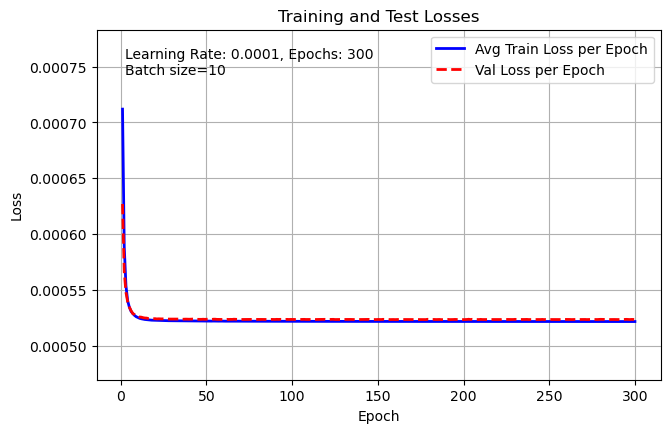

In [17]:
fig=plot_results_from_training(results_vae, trainer_vae)
fig.savefig(f'plots/task1/VAE/results_VAE_lr={lr}_epochs={num_epochs}.png', dpi=300, bbox_inches='tight')
fig.show()

In [18]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score#
from utils.plot import plot_latent_space_2d
from utils.plot import plot_confusion_matrix 


def test_anomaly_detection(model,trainer,test_loader,model_name):
    lr = trainer.lr
    num_epochs = trainer.num_epochs
    device= trainer.device

    model.eval()
    scores = []
    labels = []
    mus = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            x_hat = model(x)
            mu, logvar = model.encode(x)
            
            # Calcola loss di ricostruzione sommata per ogni esempio (batch element)
            recon_loss = F.mse_loss(x_hat, x, reduction='none')
            recon_loss = recon_loss.view(x.size(0), -1).sum(dim=1)  # somma su tutti i pixel/timepoint
            scores.append(recon_loss.cpu())
            labels.append(y)
            mus.append(mu.cpu())
    torch.cuda.empty_cache() 

    scores = torch.cat(scores).numpy()
    labels = torch.cat(labels).numpy().reshape(-1)
    mus = torch.cat(mus).numpy()
    # Plotting the latent space
    fig=plot_latent_space_2d(mus,labels,lr,num_epochs, only_quenched=False,name=model_name)
    fig.savefig(f'plots/task1/VAE/{model_name}_latent_space_lr={lr}_{num_epochs}epochs.png', dpi=300, bbox_inches='tight')
    fig.show()

    # Histograms of scores
    plt.figure(figsize=(10, 5))
    plt.hist(scores[labels == 0], bins=40, alpha=0.5, label='Normal', color='blue')
    plt.hist(scores[labels == 1], bins=40, alpha=0.5, label='Anomalous', color='red')
    plt.xlabel('scores')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} Reconstruction scores')
    plt.legend()
    plt.grid(True)

    mean_normal = scores[labels == 0].mean()
    mean_anomalous = scores[labels == 1].mean()

    plt.text(0.05, 0.95,f"lr={lr}, epochs={num_epochs} \nMean Normal: {mean_normal:.4f} \nMean Anomalous: {mean_anomalous:.4f} \nDistance: {abs(mean_normal - mean_anomalous):.4f}",
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.savefig(f"plots/task1/VAE/{model_name}_hist_scores_lr_{lr}_epochs_{num_epochs}.png")
    

    # Calcolo ROC AUC
    auc = roc_auc_score(labels, scores)
   
    # Calcolo ROC curve per trovare soglia ottimale (Youden’s J statistic)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    best_threshold = thresholds[best_idx]

    # Classificazione binaria con soglia ottimale
    preds = (scores > best_threshold).astype(int)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    # Plot ROC curve

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    ax1.plot([0,1], [0,1], 'k--')
    ax1.scatter(fpr[best_idx], tpr[best_idx], marker='o', color='red', label='Best threshold')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve-{model_name} lr={lr} epochs={num_epochs}')
    ax1.grid(True)
    ax1.legend()
    plot_confusion_matrix(labels, preds, labels=["Normal", "Anomalous"],title=f"{model_name} lr={lr} epochs={num_epochs} confusion_matrix", ax=ax2)
    plt.savefig(f"plots/task1/VAE/{model_name}_confusion_matrix_lr_{lr}_epochs_{num_epochs}.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    return best_threshold, auc, acc, prec, rec, f1


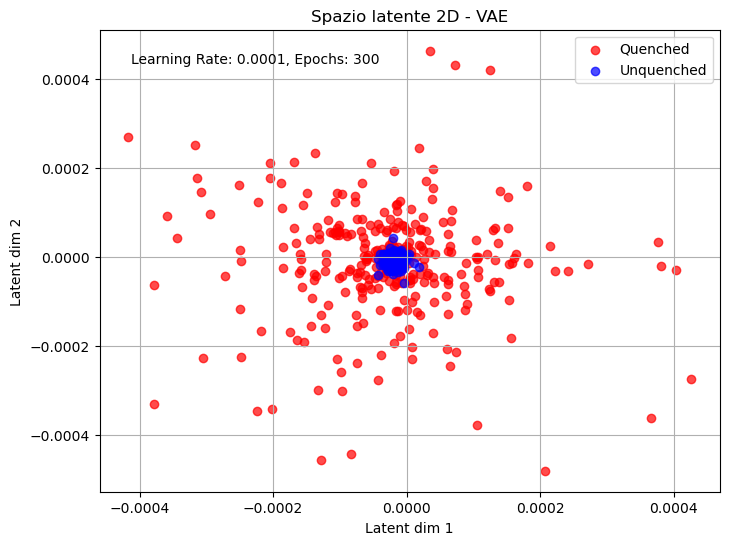

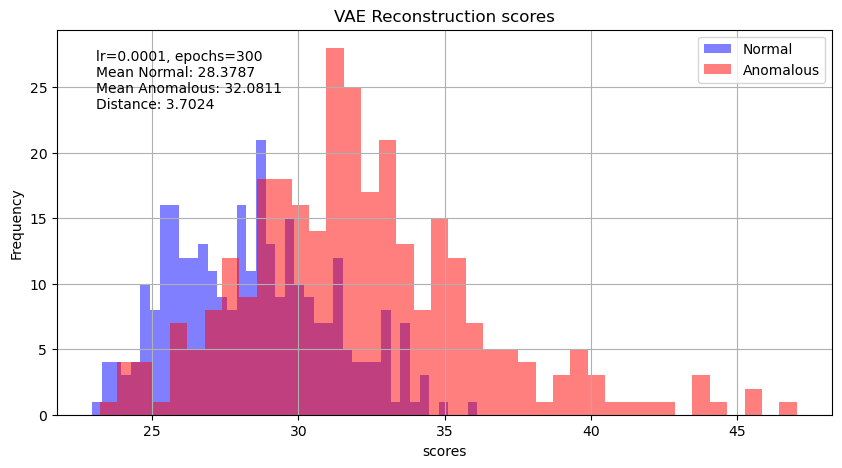

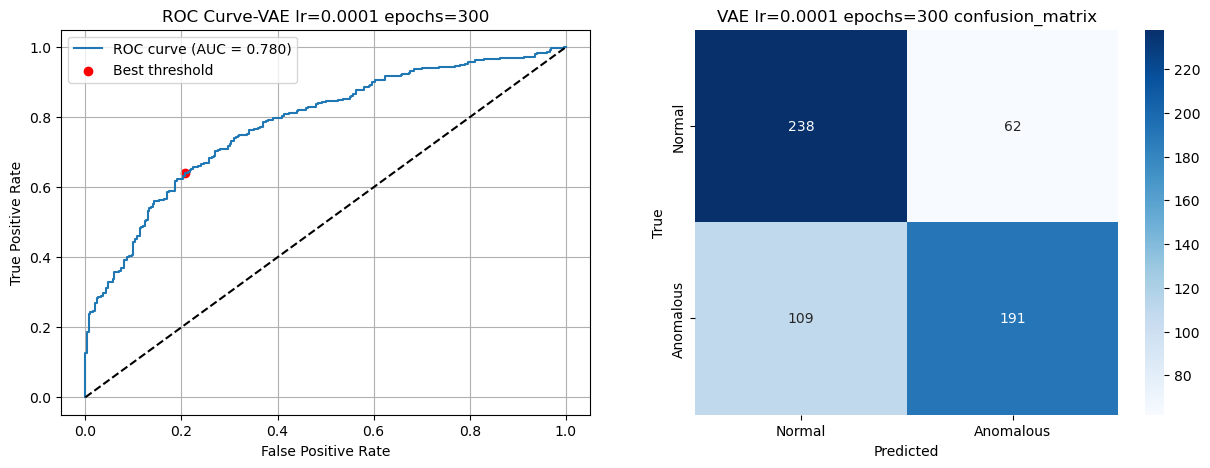

In [19]:
best_threshold, auc, acc, prec, rec, f1 = test_anomaly_detection(model_vae, trainer_vae,test_loader,'VAE')

In [20]:
print(f"Best threshold: {best_threshold:.4f}, \nAUC: {auc:.4f}, \nAccuracy: {acc:.4f}, \nPrecision: {prec:.4f},\nRecall: {rec:.4f},\nF1-score: {f1:.4f}")

Best threshold: 30.6626, 
AUC: 0.7802, 
Accuracy: 0.7150, 
Precision: 0.7549,
Recall: 0.6367,
F1-score: 0.6908


Total parameters: 22419, Trainable parameters: 22419
Epoch 1/300, Train Loss: 0.000539 | Val Loss: 0.000530 
Epoch 2/300, Train Loss: 0.000526 | Val Loss: 0.000526 
Epoch 3/300, Train Loss: 0.000524 | Val Loss: 0.000525 
Epoch 4/300, Train Loss: 0.000523 | Val Loss: 0.000524 
Epoch 5/300, Train Loss: 0.000523 | Val Loss: 0.000524 
Epoch 6/300, Train Loss: 0.000522 | Val Loss: 0.000523 
Epoch 7/300, Train Loss: 0.000522 | Val Loss: 0.000523 
Epoch 8/300, Train Loss: 0.000521 | Val Loss: 0.000522 
Epoch 9/300, Train Loss: 0.000520 | Val Loss: 0.000521 
Epoch 10/300, Train Loss: 0.000519 | Val Loss: 0.000520 
Epoch 11/300, Train Loss: 0.000518 | Val Loss: 0.000520 
Epoch 12/300, Train Loss: 0.000518 | Val Loss: 0.000519 
Epoch 13/300, Train Loss: 0.000517 | Val Loss: 0.000519 
Epoch 14/300, Train Loss: 0.000517 | Val Loss: 0.000519 
Epoch 15/300, Train Loss: 0.000517 | Val Loss: 0.000518 
Epoch 16/300, Train Loss: 0.000516 | Val Loss: 0.000518 
Epoch 17/300, Train Loss: 0.000516 | Val Los

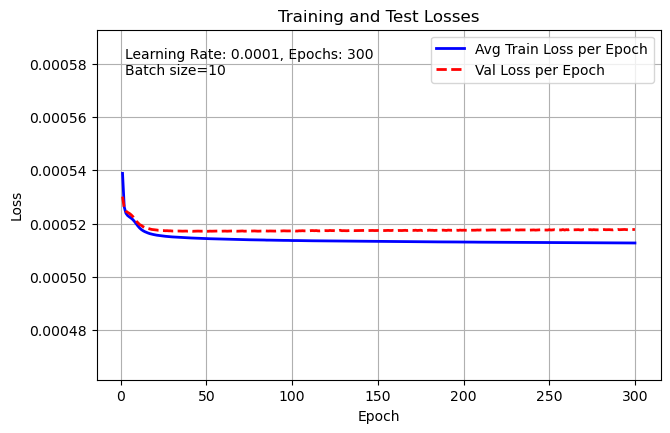

In [21]:
from train.trainer import TrainerConvAE
model_cae = ConvAE(latent_dim=2,k=1)
count_parameters(model_cae)

trainer_cae = TrainerConvAE(model_cae, cae_loss, optimizer='Adam', lr=lr, num_epochs=num_epochs, train_loader=train_loader, val_loader=val_loader)
results_cae = trainer_cae.run()
fig=plot_results_from_training(results_cae, trainer_cae)
fig.savefig(f'plots/task1/VAE/results_ConvAE_lr={lr}_epochs={num_epochs}.png', dpi=300, bbox_inches='tight')

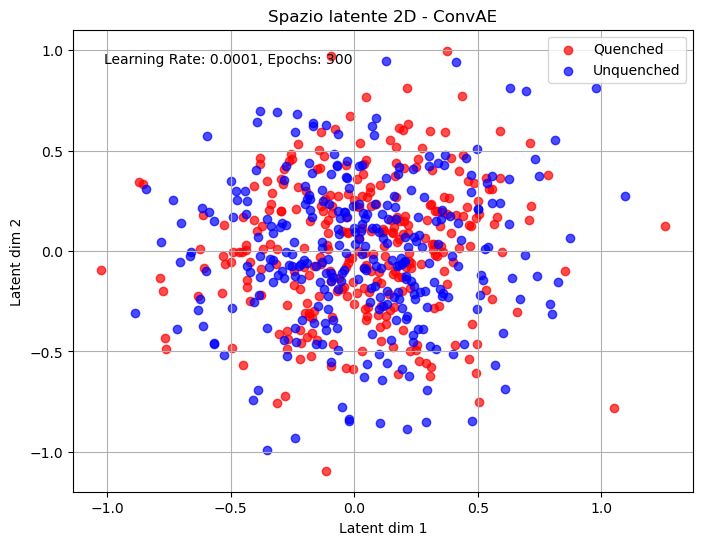

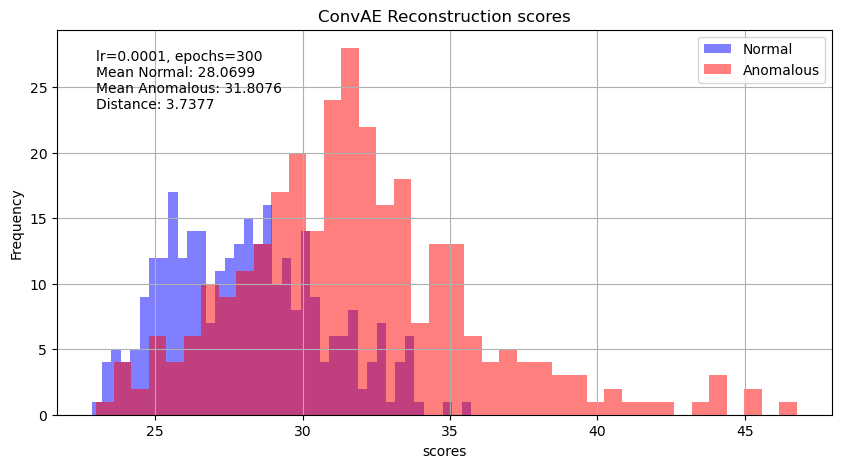

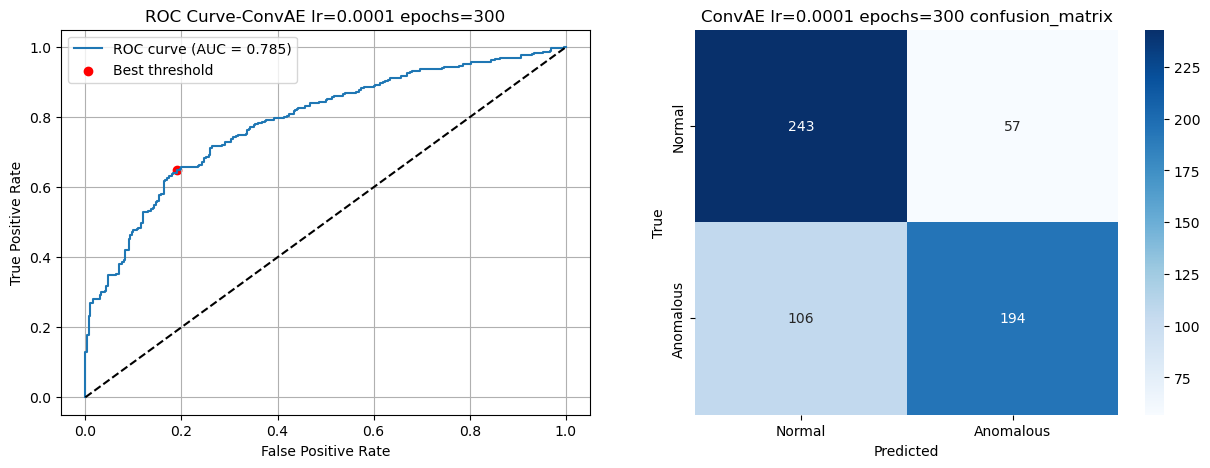

In [22]:

best_threshold, auc, acc, prec, rec, f1 = test_anomaly_detection(model_cae, trainer_cae,test_loader,'ConvAE')
